# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [11]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [12]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

In [8]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

AttributeError: ignored

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [13]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.res_size = 16 * 32
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32))
        self.conv1x1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.last_layer = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8)
        )
        self.fc = nn.Linear(in_features=self.res_size, out_features=n_classes)

    def forward(self, x):
        result = self.last_layer(self.first_layer(x) + self.conv1x1(x))
        result = self.fc(result.reshape(x.shape[0], self.res_size))
        return result

In [14]:
net = BasicBlockNet()
net

BasicBlockNet(
  (first_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (last_layer): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [15]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [17]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [19]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    criterion = nn.CrossEntropyLoss()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        out = model(data)
        loss = criterion(out, target)
        
        loss_log.append(loss.item())
        n = target.shape[0]
        acc = (torch.argmax(out, dim=1) == target).sum() / n
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out, target)
        
        
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        n = target.shape[0]
        acc = (torch.argmax(out, dim=1) == target).sum() / n


        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [20]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.495966633887352, train acc: 0.46798690919248453
 val loss: 1.30910865043072, val acc: 0.5262632978723404

Epoch 1
 train loss: 1.1896302557296683, train acc: 0.5813650758000571
 val loss: 1.087509170238008, val acc: 0.6218085106382979

Epoch 2
 train loss: 1.0690427828968334, train acc: 0.6277218269255741
 val loss: 1.0875375209970677, val acc: 0.6252216313747649

Epoch 3
 train loss: 1.0061668633760874, train acc: 0.6514796617915904
 val loss: 1.0042066566487575, val acc: 0.6542553191489362

Epoch 4
 train loss: 0.9602945506899623, train acc: 0.6641461544106604
 val loss: 1.0014160168931838, val acc: 0.6498226950777338

Epoch 5
 train loss: 0.9225116918030343, train acc: 0.6791345652540162
 val loss: 0.999242228903669, val acc: 0.6523271276595745

Epoch 6
 train loss: 0.9010948148680343, train acc: 0.6856718464351006
 val loss: 1.0020840178144739, val acc: 0.6553191489361702

Epoch 7
 train loss: 0.8848506012281072, train acc: 0.6910094019481862
 val loss: 0.929

Посчитайте точность на тестовой выборке:

In [21]:
t_loss, t_acc = test(net, test_loader)
print("loss on test ", t_loss)
print("acc on test ", t_acc)

loss on test  0.8640419734511405
acc on test  0.7032245222929936


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

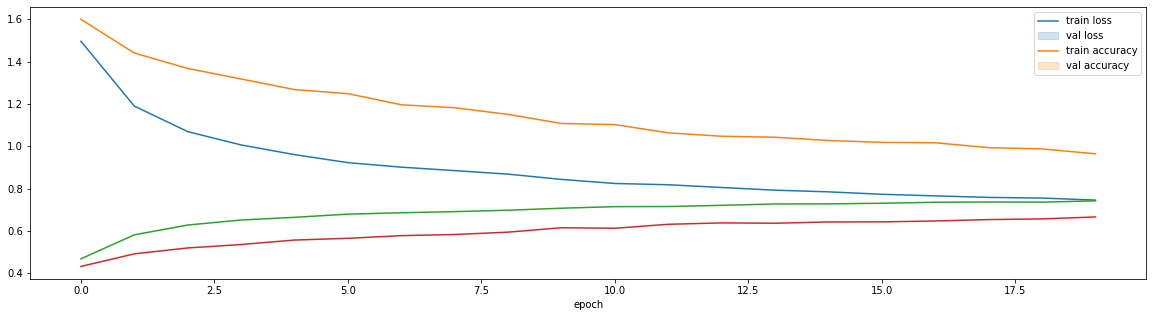

In [31]:
from seaborn import lineplot

train_loss_mean = []
train_acc_mean = []

n = len(train_loader.dataset) // 64 + 1
for i in range(0, 20 * n, n):
    train_loss_mean.append(np.mean(train_loss_log[i: i + n]))
    train_acc_mean.append(np.mean(train_acc_log[i: i + n]))

plt.figure(figsize=(20, 5))
lineplot(data=train_loss_mean)
lineplot(data=val_loss_log)
lineplot(data=train_acc_mean)
lineplot(data=val_acc_log)

plt.legend(['train loss', 'val loss', 'train accuracy', 'val accuracy'])
plt.xlabel('epoch')
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5062887788472707, train acc: 0.4622902520395938
 val loss: 1.29406740411799, val acc: 0.5456560284533399

Epoch 1
 train loss: 1.1931808076567363, train acc: 0.5820098264343778
 val loss: 1.1763125143152602, val acc: 0.5870345744680852

Epoch 2
 train loss: 1.074634580442195, train acc: 0.6273708866544789
 val loss: 1.075711659421312, val acc: 0.627061170212766

Epoch 3
 train loss: 1.01409038765121, train acc: 0.6490189997544018
 val loss: 1.0524766064704734, val acc: 0.6325354610351805

Epoch 4
 train loss: 0.9739833792341257, train acc: 0.6627056672760512
 val loss: 1.009379037390364, val acc: 0.6515070922831272

Epoch 5
 train loss: 0.9337277251144214, train acc: 0.67609444375012
 val loss: 0.9599209630742986, val acc: 0.6705895390916378

Epoch 6
 train loss: 0.9168017776836207, train acc: 0.6811300274223034
 val loss: 0.9726571663897088, val acc: 0.6723182624958931

Epoch 7
 train loss: 0.897013195689897, train acc: 0.6897770305874142
 val loss: 1.0074072264

Посчитайте точность на тестовой выборке:

In [23]:
t_loss, t_acc = test(net, test_loader)
print("loss on test ", t_loss)
print("acc on test ", t_acc)

loss on test  0.8340691969652844
acc on test  0.7107882165605095


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [27]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8158455529204234, train acc: 0.36522264301885854
 val loss: 1.5995611977069937, val acc: 0.43200354614156355

Epoch 1
 train loss: 1.5314164436277566, train acc: 0.46179648738020734
 val loss: 1.4405252603774374, val acc: 0.49155585106382976

Epoch 2
 train loss: 1.4196048203508422, train acc: 0.4972128820157792
 val loss: 1.367563792492481, val acc: 0.5193927305809996

Epoch 3
 train loss: 1.3508714180323933, train acc: 0.5269775072442984
 val loss: 1.3178954403451149, val acc: 0.5355939716734784

Epoch 4
 train loss: 1.2999653722512003, train acc: 0.545785453136486
 val loss: 1.2677343949358515, val acc: 0.5567597518575952

Epoch 5
 train loss: 1.2536173250383171, train acc: 0.5595251697726834
 val loss: 1.2485781659471227, val acc: 0.5649601063829788

Epoch 6
 train loss: 1.2148644542781264, train acc: 0.5747339384429415
 val loss: 1.1958994834981067, val acc: 0.5775709220703612

Epoch 7
 train loss: 1.1785425579744022, train acc: 0.5860333964637254
 val loss:

In [28]:
t_loss, t_acc = test(net, test_loader)
print("loss on test ", t_loss)
print("acc on test ", t_acc)

loss on test  0.9673147326821734
acc on test  0.6636146496815286


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>

Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>